In [33]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, random_split
from fastai.data.core import DataLoaders
import torch.nn as nn
from fastai.learner import Learner
from fastai.metrics import accuracy
from fastai.losses import CrossEntropyLossFlat
from torch.utils.data import TensorDataset, random_split, DataLoader
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn as nn
from fastai.learner import Learner
from fastai.losses import CrossEntropyLossFlat
from fastai.metrics import accuracy
import random
from fastai.callback.tracker import EarlyStoppingCallback
from fastai.data.core import DataLoaders


torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [34]:
df = pd.read_excel('S&P500_data.xlsx')

In [35]:
df['label'].count()

np.int64(6505)

Creamos las secuencias para la red


In [36]:
window_size = 60

def create_sequences(df, window_size=60):
    X, y = [], []
    log_rets = df['log_ret'].values
    labels   = df['label'].values

    for i in range(len(df) - window_size):
        seq = log_rets[i:i+window_size]      # 60 días pasados
        X.append(seq)
        y.append(labels[i+window_size])

    X = np.array(X)
    y = np.array(y)
    return X, y

X, y = create_sequences(df, window_size)
X.shape, y.shape

((6445, 60), (6445,))

Pasamos a tensores y hacemos el train/valid

Chat Prompot = 'Me ayudas a separar mis datos de prueba y validacion para el entrenamiento de la CNN1D'

In [37]:
# (n_samples, 60) -> (n_samples, 1, 60) para Conv1d
X_t = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
y_t = torch.tensor(y, dtype=torch.long)

dataset = TensorDataset(X_t, y_t)

# 80% train, 20% valid
n = len(dataset)
n_train = int(0.8 * n)
n_valid = n - n_train

train_ds, valid_ds = random_split(dataset, [n_train, n_valid])

batch_size = 64

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

In [38]:
dls = DataLoaders(train_dl, valid_dl)


Definimos la CNN 1D

Chat, tengo un batch size de 64 y una ventana temporal de 60 días. Ajusta una arquitectura CNN 1D basada en la tabla que te mando (Conv1D → ReLU → MaxPool → Conv1D -> ReLU -> MaxPool -> Dense), pero simplificada para mi problema de clasificación binaria. Respeta la estructura general de la tabla, pero adapta el número de parámetros a mis dimensiones (n_samples, 1, 60). Dame el modelo en PyTorch listo para usar.

Al final, a partir la versión base de ChatGPT la CNN1D hice algunos ajustes extra: aumenté el número de filtros en las capas convolucionales y añadí una capa de dropout (p = 0.3) antes de la capa totalmente conectada. Estos cambios buscan mejorar la capacidad del modelo para capturar patrones más complejos en la serie y, al mismo tiempo, reducir el sobreajuste, lo que en la práctica se tradujo en una ligera mejora del desempeño en el conjunto de validación.

In [39]:
class CNN1D(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=5, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=7, padding=3)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(2)

        self.dropout = nn.Dropout(p=0.3)
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.fc  = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.dropout(x)
        x = self.gap(x).squeeze(-1)
        return self.fc(x)

Learner

In [40]:
model = CNN1D()

learn = Learner(
    dls, model,
    loss_func=CrossEntropyLossFlat(),
    metrics=accuracy,
    wd=1e-2,
    cbs=EarlyStoppingCallback(monitor='valid_loss', patience=5)
)

learn.fit(100, lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.692440,0.689833,0.491854,00:02
1,0.685394,0.677160,0.598914,00:02
2,0.666200,0.643363,0.733902,00:02
3,0.629243,0.595084,0.730799,00:03
4,0.592177,0.563534,0.733126,00:02
5,0.569156,0.547494,0.733126,00:02
6,0.556561,0.538507,0.733902,00:02
7,0.551009,0.534321,0.733126,00:02
8,0.546492,0.532411,0.735454,00:03
9,0.543853,0.530558,0.738557,00:02


No improvement since epoch 86: early stopping


Graficar loss

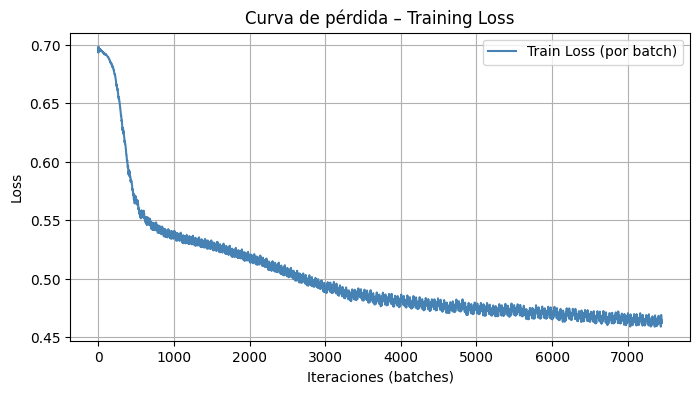

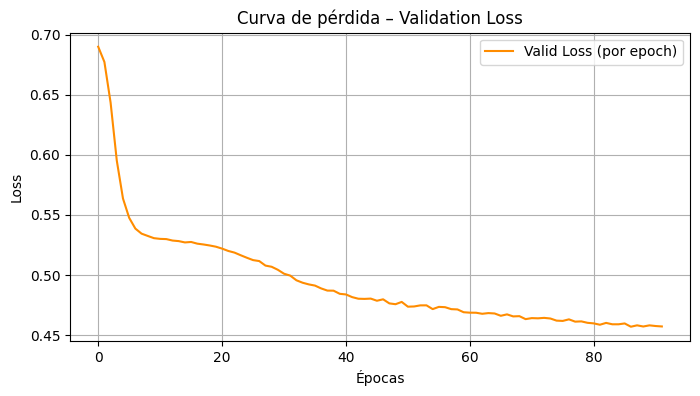

In [41]:
train_loss = [float(loss) for loss in learn.recorder.losses]

val_loss = [v[1] for v in learn.recorder.values]

# Training Loss
plt.figure(figsize=(8,4))
plt.plot(train_loss, label="Train Loss (por batch)", color='steelblue')
plt.xlabel("Iteraciones (batches)")
plt.ylabel("Loss")
plt.title("Curva de pérdida – Training Loss")
plt.grid(True)
plt.legend()
plt.show()

# Validation Loss
plt.figure(figsize=(8,4))
plt.plot(val_loss, label="Valid Loss (por epoch)", color='darkorange')
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.title("Curva de pérdida – Validation Loss")
plt.grid(True)
plt.legend()
plt.show()